In [ ]:
import torch
import torchvision
import torch.nn as nn
import os
import matplotlib.pyplot as plt
from torchsummary import summary
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

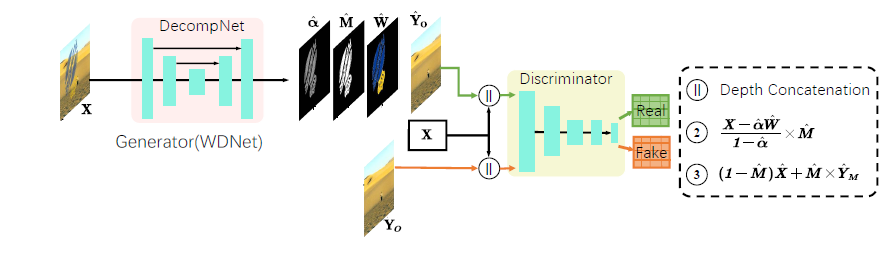

In [ ]:
class Dataset(torch.utils.data.Dataset):

  def __init__(self, dtry):
    self.dtry = dtry
    self.ids = []
    #for file in os.listdir(self.dtry+'/Watermarked_image'):
    #  self.ids.append(file.strip('.jpg'))
    #self.ids = self.ids[:1000]
    self.ids = [str(x) for x in range(1,11)]   
  def __len__(self):
    return len(self.ids)
  
  def __getitem__(self,idx):
    x = torchvision.io.read_image(f'{self.dtry}/Watermarked_image/{self.ids[idx]}.jpg')/255.0
    y = torchvision.io.read_image(f'{self.dtry}/Watermark_free_image/{self.ids[idx]}.jpg')/255.0
    m = torchvision.io.read_image(f'{self.dtry}/Mask/{self.ids[idx]}.png')/255.0
    a = torchvision.io.read_image(f'{self.dtry}/Alpha/{self.ids[idx]}.png')/255.0
    w = torchvision.io.read_image(f'{self.dtry}/Watermark/{self.ids[idx]}.png')/255.0

    return x, y, m, a, w

In [ ]:
#torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
#torch.nn.MaxPool2d(kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)
#torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0, groups=1, bias=True, dilation=1, padding_mode='zeros')

class DoubleConv(nn.Module):

  def __init__(self, in_channels, out_channels):
    super(DoubleConv, self).__init__()
    self.conv = nn.Sequential(nn.Conv2d(in_channels, out_channels, 3, 1, 1),
                              nn.BatchNorm2d(out_channels),
                              nn.ReLU(inplace=True),
                              nn.Conv2d(out_channels, out_channels, 3, 1, 1),
                              nn.BatchNorm2d(out_channels),
                              nn.ReLU(inplace=True))
  def forward(self, x):
    return self.conv(x)

class UNet(nn.Module):

  def __init__(self, in_channels=3, out_channels=1, filters=[64, 128, 256, 512]):
    super(UNet, self).__init__()
    self.ups = nn.ModuleList()
    self.downs = nn.ModuleList()
    self.link = DoubleConv(filters[-1], filters[-1]*2)

    for n_filters in filters:
      self.downs.append(DoubleConv(in_channels, n_filters))
      self.downs.append(nn.MaxPool2d(2, 2))
      in_channels = n_filters
    
    for n_filters in reversed(filters):
      self.ups.append(nn.ConvTranspose2d(n_filters*2, n_filters, 2, 2))
      self.ups.append(DoubleConv(n_filters*2, n_filters))
    self.ups.append(nn.Conv2d(filters[0], out_channels, 1))
    
  def forward(self, x):
    skip_conctns = []
    
    for idx, down in enumerate(self.downs):
      x = down(x)
      if idx%2 == 0:
        skip_conctns.append(x)
        
    x = self.link(x)
    skip_conctns = skip_conctns[::-1]
    
    for idx in range(0, len(self.ups)-1, 2):
      x = self.ups[idx](x)
      skip_conctn = skip_conctns[idx//2]
      
      if skip_conctn.shape != x.shape:
        skip_conctn = torchvision.transforms.functional.resize(skip_conctn, size=x.shape[2:])
        
      concat = torch.cat((skip_conctn,x), dim=1)
      x = self.ups[idx+1](concat)
        
    return x

class OutConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(OutConv, self).__init__()
    self.conv = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=1),
                              nn.Sigmoid()
                              )

  def forward(self, x):
    return self.conv(x)

In [ ]:
#Note:-
# 1. UNet doesnt change the dimensions of the input image
# 2. Dilated convolution layers do not change the dimensions of the input
# 3. Post process layers also do not change the dimensions of the input
# 4. In total Generator does not change the shape of the input
#Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
class Generator(nn.Module):
  # Network Architecture is exactly same as in infoGAN (https://arxiv.org/abs/1606.03657)
  # Architecture : FC1024_BR-FC7x7x128_BR-(64)4dc2s_BR-(1)4dc2s_S
  def __init__(self, n_channels, n_classes, bilinear=True):
    super(Generator, self).__init__()
    self.n_channels = n_channels
    self.n_classes = n_classes
    self.bilinear = bilinear

    self.unet = UNet()
    self.outa = OutConv(64, 3)
    self.outm = OutConv(64, 3)
    self.outw = OutConv(64, 3)
    
  def forward(self, x0):
    x = self.unet(x0)
    a = self.outa(x)
    m = self.outm(x)
    w = self.outw(x)
    y_m = (x0*m-a*w)/(1.0-a+1e-6)
    y = y_m*m+(1.0-m)*x0
    return y, m, a, w, y_m

class Discriminator(nn.Module):
  # Network Architecture is exactly same as in infoGAN (https://arxiv.org/abs/1606.03657)
  # Architecture : (64)4c2s-(128)4c2s_BL-FC1024_BL-FC1_S
  def __init__(self, input_dim=3, output_dim=1):
    super(Discriminator, self).__init__()
    self.input_dim = input_dim
    self.output_dim = output_dim

    self.conv = nn.Sequential(
      nn.Conv2d(self.input_dim, 64, 4, 2, 2),
      nn.BatchNorm2d(64),
      nn.LeakyReLU(0.2),
      nn.Conv2d(64, 128, 3, 2, 1),
      nn.BatchNorm2d(128),
      nn.LeakyReLU(0.2),
      nn.Conv2d(128, 256, 3, 1, 1),
      nn.BatchNorm2d(256),
      nn.LeakyReLU(0.2),
      nn.Conv2d(256, 1, 3, 1, 1),
      nn.Sigmoid()
    )

  def forward(self, input, label):
    x = torch.cat([input, label], 1)
    x = self.conv(x)
    return x

In [ ]:
class WDNet(object):
  def __init__(self, args):
  
    # parameters
    self.n_epochs = args['n_epochs']
    self.dtry = args['dtry']
    self.batch_size = args['batch_size']
    self.dataset = args['dataset']
    self.gpu_mode = args['gpu_mode']

    # load dataset
    self.data_loader = torch.utils.data.DataLoader(self.dataset, self.batch_size, num_workers=4)
    
    # networks init
    self.G = Generator(3, 3)
    self.D = Discriminator(input_dim=6, output_dim=1)
    self.load()
    self.G_optimizer = torch.optim.Adam(self.G.parameters(), lr=args['lrG'], betas=(args['beta1'], args['beta2']))
    self.D_optimizer = torch.optim.Adam(self.D.parameters(), lr=args['lrD'], betas=(args['beta1'], args['beta2']))
    
    if self.gpu_mode:
      self.G.cuda()
      self.D.cuda()
      self.BCE_loss = nn.BCELoss().cuda()
      self.l1loss=nn.L1Loss().cuda()
      self.loss_mse = nn.MSELoss().cuda()
    else:
      self.l1loss = nn.L1Loss()
      self.BCE_loss = nn.BCELoss()

  def train(self):
    self.train_hist = {}
    self.train_hist['G_loss'] = []
    self.train_hist['D_loss'] = []
    self.G.train()
    self.D.train()
    for epoch in range(self.n_epochs):
      loop = tqdm(self.data_loader,  position=0, leave=True)
      for iter, (x, y, m, a, w) in enumerate(loop):
        if self.gpu_mode:
            x, y, m, a, w = x.cuda(), y.cuda(), m.cuda(), a.cuda(), w.cuda()
        
        # update G network
        self.G_optimizer.zero_grad()
        g_y, g_m, g_a, g_w, g_y_m = self.G(x)
        D_fake = self.D(x, g_y)
        G_loss = self.BCE_loss(D_fake, torch.ones_like(D_fake))
        m_loss=self.l1loss(g_m,m)
        w_loss=self.l1loss(g_w*m,w*m)
        a_loss=self.l1loss(g_a*m,a*m)
        y_m_loss=self.l1loss(g_y*m,y*m)
        G_loss=G_loss+10.0*m_loss+10.0*w_loss+10.0*a_loss+50.0*y_m_loss
        self.train_hist['G_loss'].append(G_loss.item())
        G_loss.backward()
        self.G_optimizer.step()
        
        # update D network
        if (iter%1)==0 :
          self.D_optimizer.zero_grad()
    
          D_real = self.D(x, y)
          D_real_loss = self.BCE_loss(D_real, torch.ones_like(D_real))
    
          g_y, g_m, g_a, g_w, g_y_m = self.G(x)
          D_fake = self.D(x,g_y)
          D_fake_loss = self.BCE_loss(D_fake, torch.zeros_like(D_fake))
    
          D_loss = 0.5*D_real_loss + 0.5*D_fake_loss
          self.train_hist['D_loss'].append(D_loss.item())
          D_loss.backward()
          self.D_optimizer.step()
        loop.set_postfix(loss=(G_loss.item(),D_loss.item()))
      self.save()
    self.save()

  def save(self):
    torch.save(self.G.state_dict(), os.path.join(self.dtry,'WDNet_G.pkl'))
    torch.save(self.D.state_dict(), os.path.join(self.dtry,'WDNet_D.pkl'))
  
  def load(self):
    self.G.load_state_dict(torch.load(os.path.join(self.dtry,'WDNet_G.pkl')))
    self.D.load_state_dict(torch.load(os.path.join(self.dtry,'WDNet_D.pkl')))

In [ ]:
dataset = Dataset('drive/MyDrive/CLWD/train')
args = {'dtry':'drive/MyDrive/CLWD','n_epochs':10,'batch_size':2,\
        'dataset':dataset,'gpu_mode':False,'lrG':0.2,'lrD':0.2,'beta1':0.5,'beta2':0.999}
model = WDNet(args)
model.train()